In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [15]:
from estimators.train import get_params, TrainAndEvaluate
from estimators.models.resnet import *
from torchvision.transforms import ToTensor, Compose
from estimators.data.transformations import RandomCoarsening, RandomSimplexNoise, CenterAndScalePatch
from torch.nn import Dropout
from estimators.models import zoo
from torchsummary import summary


In [29]:
params = get_params()
params

{'epochs': 30,
 'lr': 0.0001,
 'batch_size': 128,
 'val_size': 10,
 'test': None,
 'validation': None,
 'model': 'microresnet#4-gate=3x3-n=1-se=False',
 'dataset': '',
 'sampler': None,
 'num_samples': None,
 'data-aug': (None, None),
 'train_transform_with_label': None,
 'train_transform': Compose(
     ToTensor()
 ),
 'val_transform': Compose(
     ToTensor()
 ),
 'test_transform': Compose(
     ToTensor()
 ),
 'optim': functools.partial(<class 'torch.optim.sgd.SGD'>, mentum=0.95, weight_decay=0.0001),
 'info': '',
 'tr': 0.2,
 'problem': 'classification',
 'more_than': None,
 'less_than': None,
 'down_sampling': 2,
 'time_window': 100,
 'patch_size': 0.71}

[INFO] 1500 simulations for training.
[INFO] train_trasform = Compose(
    ToTensor()
    Dropout(p=0.1)
)
None
[INFO] val root = /media/francesco/saetta/krock-dataset/val/
[INFO] Using test root = /media/francesco/saetta/krock-dataset/new-test-random/


<IPython.core.display.Javascript object>


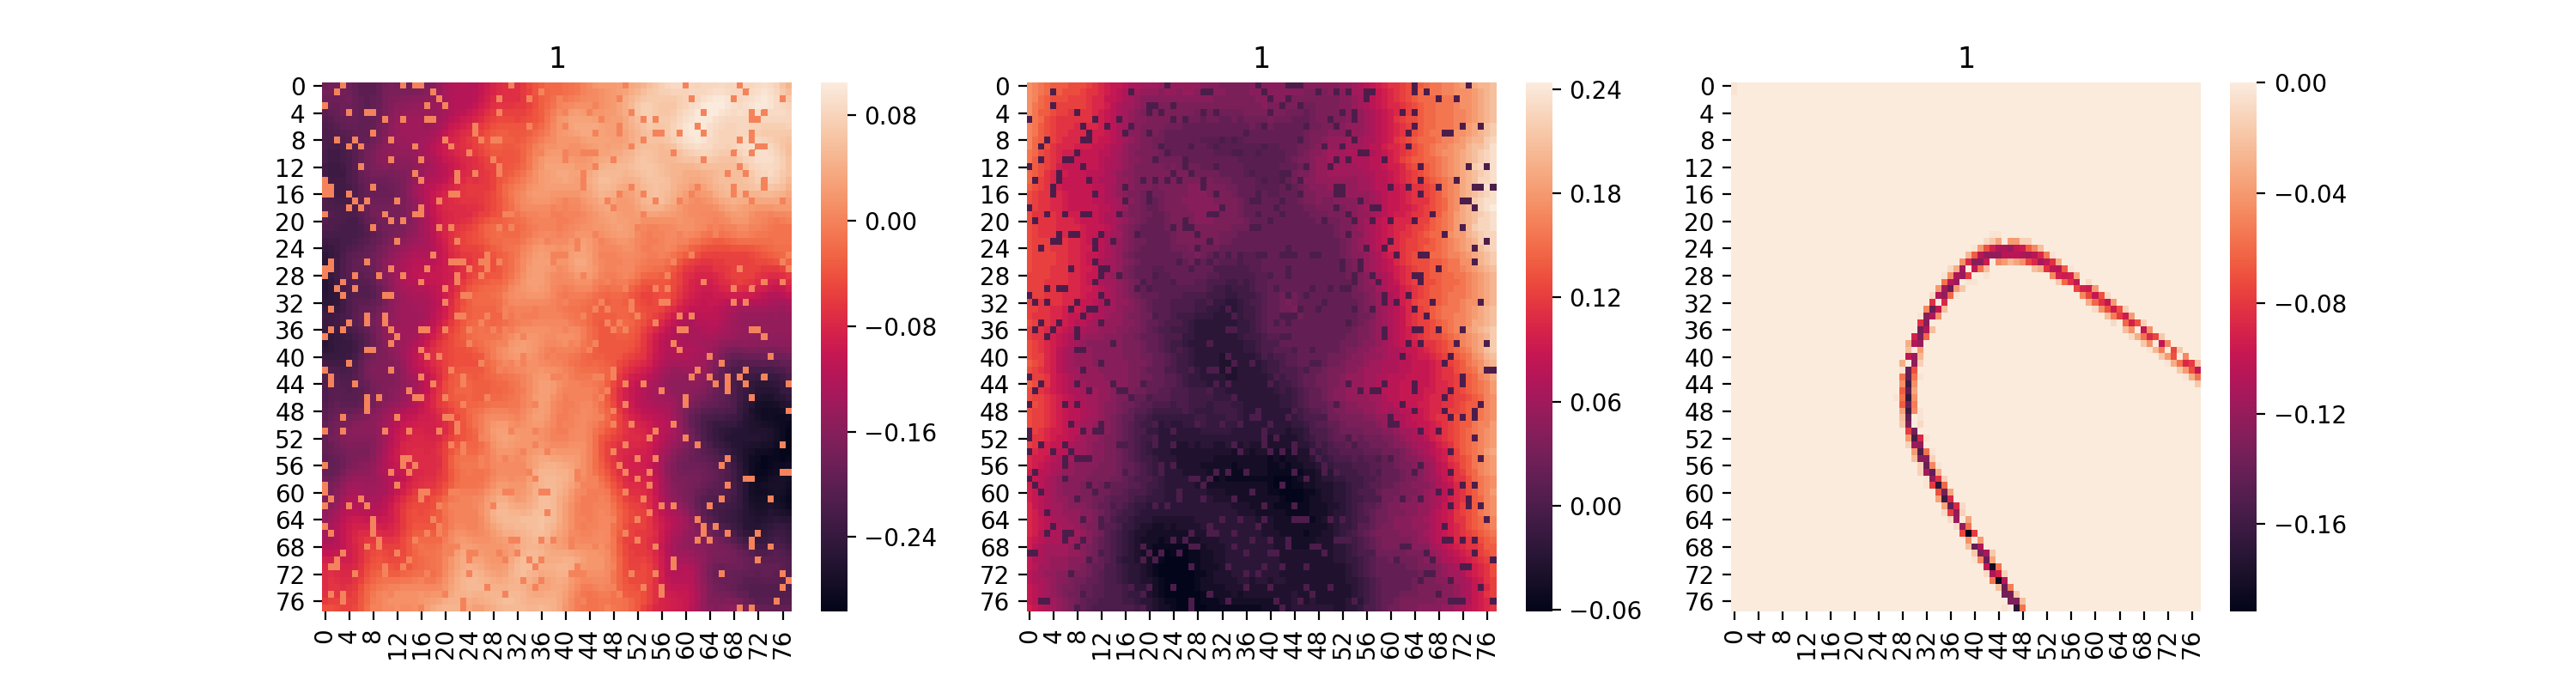

<IPython.core.display.Javascript object>


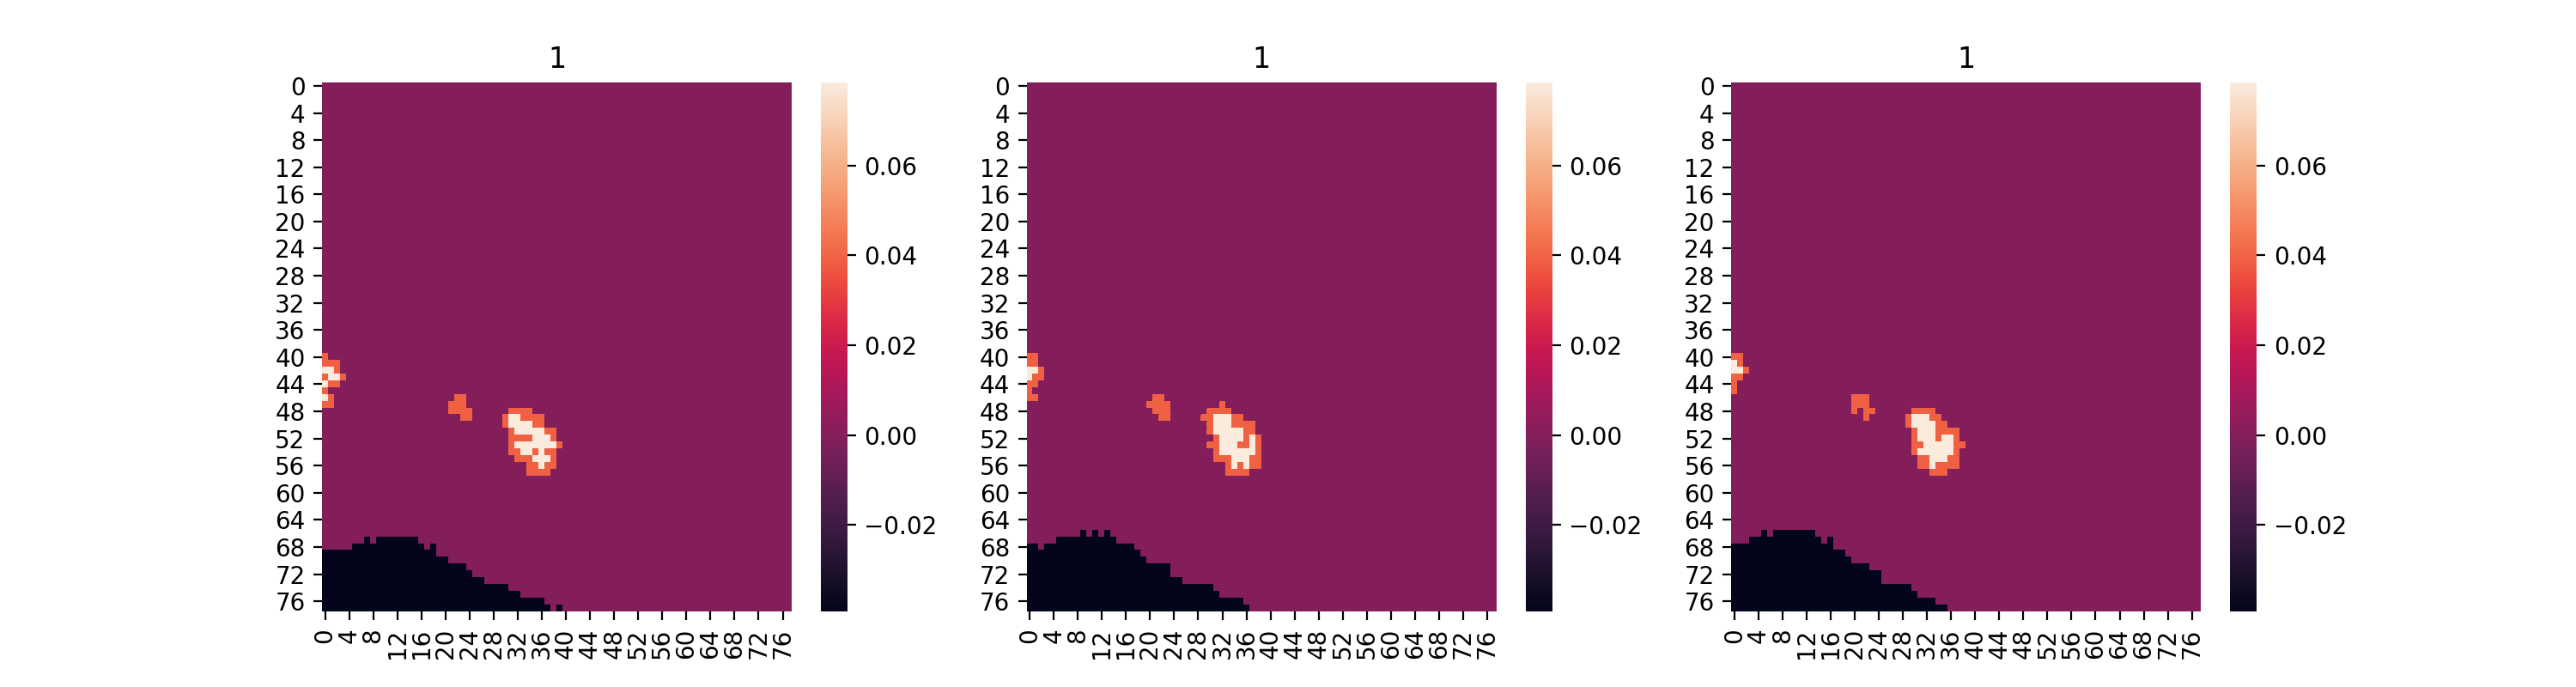

In [33]:
params['validation'] = '/media/francesco/saetta/krock-dataset/val/'
params['test'] = '/media/francesco/saetta/krock-dataset/new-test-random/'
# validate_transformation = Compose([CenterAndScalePatch(), ToTensor])
train_transform = Compose([CenterAndScalePatch(), ToTensor(), Dropout(0.1)])
params['train_transform'] = train_transform
params['epoches'] = 5
train_and_evaluate = TrainAndEvaluate(params)

In [14]:
from estimators.models import zoo
from utilities.postprocessing.utils import KrockPatchExtractStrategy


In [12]:
zoo['omar']()

OmarCNN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=7605, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [36]:
class Encoder3x3(ResNetEncoder):
    def __init__(self, in_channel, depths, *args, **kwargs):
        super().__init__(in_channel, depths, *args, **kwargs)

        self.gate = nn.Sequential(
            nn.Conv2d(in_channel, self.blocks_sizes[0][0], kernel_size=3, stride=1, bias=False, padding=1),
            nn.BatchNorm2d(self.blocks_sizes[0][0]),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

In [10]:
micro = zoo['microresnet#4-gate=3x3-n=1-se=True']()
model = lambda : ResNet(
        in_channel=1,
        # encoder=Encoder3x3,
        decoder=MyDecoder,
        depths=[1, 1, 1],
        blocks=[BasicBlock, BasicBlock, BasicBlock],
        blocks_sizes=[(32, 32), (32, 64),  (64, 128)],
        n_classes=2)

    
class MyDecoder(ResnetDecoder):
    def __init__(self, in_features, n_classes):
        super().__init__(in_features, n_classes)
#         self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Dropout(),
            nn.Linear(64, n_classes),

        )


In [16]:
summary(model().cuda(), (1, 79, 79))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 40]           1,568
       BatchNorm2d-2           [-1, 32, 40, 40]              64
         LeakyReLU-3           [-1, 32, 40, 40]               0
         MaxPool2d-4           [-1, 32, 20, 20]               0
            Conv2d-5           [-1, 32, 20, 20]           9,216
       BatchNorm2d-6           [-1, 32, 20, 20]              64
              ReLU-7           [-1, 32, 20, 20]               0
            Conv2d-8           [-1, 32, 20, 20]           9,216
       BatchNorm2d-9           [-1, 32, 20, 20]              64
       BasicBlock-10           [-1, 32, 20, 20]               0
      ResNetLayer-11           [-1, 32, 20, 20]               0
           Conv2d-12           [-1, 64, 10, 10]           2,048
      BatchNorm2d-13           [-1, 64, 10, 10]             128
           Conv2d-14           [-1, 64,

In [37]:
validate_transformation = Compose([CenterAndScalePatch(), ToTensor])
train_transformation = Compose([CenterAndScalePatch(), ToTensor])
params = get_params()

patch_size = KrockPatchExtractStrategy.patch_shape(params['patch_size'], 0.02)

model = lambda : ResNet(
    in_channel=1,
#     encoder=Encoder3x3,
    depths=[1, 1, 1],
    blocks=[BasicBlock, BasicBlock, BasicBlock],
    blocks_sizes=[(64, 64), (64, 128),  (128, 256)],
    n_classes=2)

In [38]:
train_and_evaluate('omar')

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/francescosaveriozuppichini/i-love-krock/ec38cd886bec4c40a246b1c1d777866e
COMET INFO:   Metrics:
COMET INFO:               sys.gpu.0.free_memory: 7123304448
COMET INFO:           sys.gpu.0.gpu_utilization: 0
COMET INFO:              sys.gpu.0.total_memory: 8510832640
COMET INFO:               sys.gpu.0.used_memory: 1387528192
COMET INFO:                           timestamp: 1558554378.4767954
COMET INFO:                      train_accuracy: tensor(0.9364)
COMET INFO:                    train_curr_epoch: 3
COMET INFO:                 train_custom_metric: 62.099103689193726
COMET INFO:                          train_loss: 0.19466754794120789
COMET INFO:         train_sys.gpu.0.free_memory: 6211436544
COMET INFO:     train_sys.gpu.0.gpu_utilization: 0
COMET INFO:         train_sys.gpu.0.used_memory: 2299396096
COMET INFO:                      train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 79, 79]              45
       BatchNorm2d-2            [-1, 5, 79, 79]              10
              ReLU-3            [-1, 5, 79, 79]               0
            Conv2d-4            [-1, 5, 79, 79]             225
       BatchNorm2d-5            [-1, 5, 79, 79]              10
              ReLU-6            [-1, 5, 79, 79]               0
         MaxPool2d-7            [-1, 5, 39, 39]               0
            Conv2d-8            [-1, 5, 39, 39]             225
       BatchNorm2d-9            [-1, 5, 39, 39]              10
             ReLU-10            [-1, 5, 39, 39]               0
           Linear-11                  [-1, 128]         973,568
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

COMET INFO: old comet version (1.0.53) detected. current: 1.0.54 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/francescosaveriozuppichini/i-love-krock/f91c85c2bca0408fb676c3a20684c4f5

COMET ERROR: Failed to run Learner.__init__ logger


train size=230912, val size=21888, test size=36224


TypeError: __init__() got an unexpected keyword argument 'mentum'